In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import torch
from tqdm.notebook import tqdm

In [2]:
def compute_iou(annotation, mask):
    """Annotation: ground truth (512, 512), Mask: prediction (512, 512)"""

    # Compute intersection
    intersection = np.sum(np.logical_and(annotation, mask))

    # Compute union
    union = np.sum(np.logical_or(annotation, mask))

    # Compute intersection over union
    iou_score = intersection / union

    return intersection, union, iou_score


def interpolate(heatmap: np.ndarray, size=(512, 512), mode="bilinear"):
    """Interpolate heatmap to match the size of the ground truth"""

    # Convert to torch tensor
    heatmap = torch.from_numpy(heatmap)
    # Add batch and channel dimension
    heatmap = heatmap.unsqueeze(0)
    if heatmap.ndim != 4:
        heatmap = heatmap.unsqueeze(0)
    # Interpolate
    heatmap = torch.nn.functional.interpolate(heatmap, size=size, mode=mode)
    # Convert back to numpy
    heatmap = heatmap.squeeze().squeeze().numpy()

    return heatmap

In [3]:
import denseCRF
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys

def densecrf(I, P):
    """
    input parameters:
        I    : a numpy array of shape [H, W, C], where C should be 3.
               type of I should be np.uint8, and the values are in [0, 255]
        P    : a probability map of shape [H, W, L], where L is the number of classes
               type of P should be np.float32
        param: a tuple giving parameters of CRF (w1, alpha, beta, w2, gamma, it), where
                w1    :   weight of bilateral term, e.g. 10.0
                alpha :   spatial distance std, e.g., 80
                beta  :   rgb value std, e.g., 15
                w2    :   weight of spatial term, e.g., 3.0
                gamma :   spatial distance std for spatial term, e.g., 3
                it    :   iteration number, e.g., 5
    output parameters:
        out  : a numpy array of shape [H, W], where pixel values represent class indices. 
    """
    w1    = 10.0  # weight of bilateral term
    alpha = 80    # spatial std
    beta  = 13    # rgb  std
    w2    = 3.0   # weight of spatial term
    gamma = 3     # spatial std
    it    = 5.0   # iteration
    param = (w1, alpha, beta, w2, gamma, it)
    out = denseCRF.densecrf(I, P, param) 
    return out   

## OVAM

## VOC-sim

In [ ]:
dataset_path = Path('voc_sim')

annotations_folder = Path('../ovam/voc_sim/annotations')
images_folder = Path('../ovam/voc_sim/images')
sa_folder =  Path('../ovam_sa/voc_sim/sa')


def load_heatmap(classname, seed, strategy, t, opt):
        
        opt_suffix = "_opt" if opt else ""
        filename = dataset_path / f"{classname}_{seed.replace('seed', '')}_epochs{opt_suffix}.npy"
        heatmap = np.load(filename)
        assert heatmap.ndim == 4, f"Heatmap {filename} has wrong shape {heatmap.shape}"
        
        if strategy == 'equal':
            heatmap = heatmap[t]
        if strategy == 'greater_eq':
            heatmap = heatmap[t:].sum(axis=0)
        if strategy == 'less_eq':
            heatmap = heatmap[:t].sum(axis=0)
        return heatmap

# Hyperparameters without optimization
threshold = 0.4 # Threshold used in the paper DAAM
min_sa = 0.85

# Threshold found empirically using the training set employed for optimizng the tokens
threshold_optimized = 0.75
min_sa_optimized = 0.95

apply_crf = True
suffix_crf = "_crf" if apply_crf else ""
strategy = 'equal'



re_results = []
# Eight combinations of res16, res32, res64
# for res16, res32, res64 in [(True, True, True), (True, True, False), (True, False, True), (True, False, False),
#                             (False, True, True), (False, True, False), (False, False, True)]:

pbar = tqdm(total=30*3)
for T in range(1, 31):
    for strategy in ['equal', 'greater_eq', 'less_eq']:
            # Iterate throuth annotations
            results = []

            for annotation_path in tqdm(list(annotations_folder.iterdir())):
                example_result_dict = {}
                classname, model, seed, _ = annotation_path.stem.split('_')
                image_path = images_folder / f"{classname}_{model}_{seed}.png"
                sa_path = sa_folder / f"sa15_{classname}_{seed.replace('seed', '')}_sa.npy"
                heatmap = load_heatmap(classname, seed, strategy=strategy, t=T, opt=False)
                heatmap_optimized = load_heatmap(classname, seed, strategy=strategy, t=T, opt=True)
                
                
                # Check all exists
                assert annotation_path.exists(), f"Annotation {annotation_path} does not exist"
                assert image_path.exists(), f"Image {image_path} does not exist"
                assert sa_path.exists(), f"SA {sa_path} does not exist"
                assert heatmap.shape[1:] == (64, 64), f"Heatmap {heatmap_path} has wrong shape {heatmap.shape}"
                assert heatmap.shape[0] < 10, f"Heatmap {heatmap_path} has wrong shape {heatmap.shape}"
                assert heatmap_optimized.shape[1:] == (64, 64), f"Heatmap {heatmap_optimized_path} has wrong shape {heatmap_opt.shape}"
                assert heatmap_optimized.shape[0] == 2

                
                example_result_dict['classname'] = classname
                example_result_dict['model'] = model
                example_result_dict['seed'] = seed
                example_result_dict['image_path'] = image_path.name
                example_result_dict['annotation_path'] = annotation_path.name
                
                

                # Load image
                image = np.array(Image.open(image_path))
                assert image.shape == (512, 512, 3), f"Image {image_path} has wrong shape {image.shape}"
                
                # Load annotation. Convert in binary mask
                annotation = np.array(Image.open(annotation_path))
                assert annotation.shape == (512, 512, 3), f"Annotation {annotation_path} has wrong shape {annotation.shape}"
                annotation = annotation.sum(axis=-1) != 0
                assert annotation.shape == (512, 512), f"Annotation aggregated {annotation_path} has wrong shape {annotation.shape}"
                
                
                # Load Self-Attention map
                sa = np.load(sa_path)
                assert sa.shape == (64, 64)
                sa = interpolate(sa, size=(512, 512))
                assert sa.shape == (512, 512)


                # Reescale self-attention to [min_sa, 1]
                sa = (sa - sa.min()) / (sa.max() - sa.min())
                sa = sa * (1 - min_sa) + min_sa
                assert abs(sa.min()- min_sa) < 0.001, f"Min sa {sa.min()} is not {min_sa}"
                assert abs(sa.max()- 1) < 0.001, f"Max sa {sa.max()} is not 1"
                
                # Binarize using DAAM procedure
                heatmap = interpolate(heatmap[-2], size=(512, 512))
                assert heatmap.shape == (512, 512), f"Heatmap {heatmap_path} has wrong shape {heatmap.shape}"
                heatmap = heatmap / heatmap.max()
                heatmap = heatmap * sa # Apply sa
                mask = heatmap > threshold

                if apply_crf:
                    mask = np.stack([1 - mask, mask], axis=-1).astype(np.float32)
                    mask = densecrf(image, mask)

                assert mask.shape == (512, 512), f"Mask {mask} has wrong shape {mask.shape}"

                i_normal, u_normal, iou_normal = compute_iou(annotation=annotation, mask=mask)
                example_result_dict['iou_normal'] = iou_normal
                example_result_dict['i_normal'] = i_normal
                example_result_dict['u_normal'] = u_normal


                
                # Load mask (optimized)
                heatmap_optimized = heatmap_optimized[1] # We stored in 0 the background and in 1 the token related to the foreground object
                assert heatmap_optimized.shape == (64, 64), f"Heatmap {heatmap_optimized_path} has wrong shape {heatmap_optimized.shape}"
                heatmap_optimized = interpolate(heatmap_optimized, size=(512, 512))
                assert heatmap_optimized.shape == (512, 512), f"Heatmap {heatmap_optimized_path} has wrong shape {heatmap_optimized.shape}"


                # Reescale self-attention to [min_sa_optimized, 1]
                sa = (sa - sa.min()) / (sa.max() - sa.min())
                sa = sa * (1 - min_sa_optimized) + min_sa_optimized
                assert abs(sa.min()- min_sa_optimized) < 0.001, f"Min sa {sa.min()} is not {min_sa}"
                assert abs(sa.max()- 1) < 0.001, f"Max sa {sa.max()} is not 1"

                # Binarize using DAAM procedure
                heatmap_optimized = heatmap_optimized / heatmap_optimized.max()
                heatmap_optimized = heatmap_optimized * sa
                mask_optimized = heatmap_optimized > threshold_optimized
                if apply_crf:
                    mask_optimized = np.stack([1 - mask_optimized, mask_optimized], axis=-1).astype(np.float32)
                    mask_optimized = densecrf(image, mask_optimized)

                assert mask_optimized.shape == (512, 512), f"Mask {mask_optimized} has wrong shape {mask_optimized.shape}"

                i_optimized, u_optimized, iou_optimized = compute_iou(annotation=annotation, mask=mask_optimized)
                example_result_dict['iou_optimized'] = iou_optimized
                example_result_dict['i_optimized'] = i_optimized
                example_result_dict['u_optimized'] = u_optimized

                results.append(example_result_dict)

                

            # Aggregated by example
            df_results = pd.DataFrame(results)
            df_results['experiment'] = "voc-sim - daam"
            # df_results.to_csv(dataset_path / f'ovam_voc_sim_results_sa{suffix_crf}.csv', index=False)


            # Aggregated results by class
            df_classes = df_results.groupby(['classname', 'model']).aggregate({'i_normal': 'sum', 'u_normal': 'sum', 'i_optimized': 'sum', 'u_optimized': 'sum'}).reset_index()
            df_classes['iou_normal'] = df_classes['i_normal'] / df_classes['u_normal']
            df_classes['iou_optimized'] = df_classes['i_optimized'] / df_classes['u_optimized']
            df_classes['experiment'] = "voc-sim - ovam"
            df_classes = df_classes.sort_values('classname').reset_index(drop=True)
            # df_classes.to_csv(dataset_path / f'ovam_voc_sim_class_results_sa{suffix_crf}.csv', index=False)

            df_overall = df_classes.groupby('model').aggregate({'i_normal': 'sum', 'u_normal': 'sum', 'i_optimized': 'sum', 'u_optimized': 'sum',
                                                    'iou_normal': 'mean', 'iou_optimized': 'mean'}).reset_index()

            df_overall.rename(columns={'iou_normal': 'miou_normal', 'iou_optimized': 'miou_optimized'}, inplace=True)
            df_overall['iou_overall_normal'] = df_overall['i_normal'] / df_overall['u_normal']
            df_overall['iou_overall_optimized'] = df_overall['i_optimized'] / df_overall['u_optimized']
            df_overall['experiment'] = "voc-sim - ovam"

            #df_overall.to_csv(dataset_path / f'ovam_voc_sim_overall_results_sa{suffix_crf}.csv', index=False)

            df_overall_display = df_overall[["miou_normal","iou_overall_normal", "miou_optimized",  "iou_overall_optimized"]]
            df_overall_display = (100*df_overall_display).round(1)
            df_overall_display["strategy"] = strategy
            df_overall_display["timestep"] = T
            df_overall_display["dcrf"] = apply_crf
            #display(df_overall_display)
            re_results.append(df_overall_display)
            pbar.update(1)


df_reresults = pd.concat(re_results)
df_reresults.to_csv("voc_sim_timestep_ablation.csv")



In [ ]:
import seaborn as sns

# Lineplot x = timestep, y = miou_normal, hue = strategy
sns.set_theme(style="whitegrid")
sns.lineplot(x="timestep", y="miou_optimized", hue="strategy", data=df_reresults, marker='o')

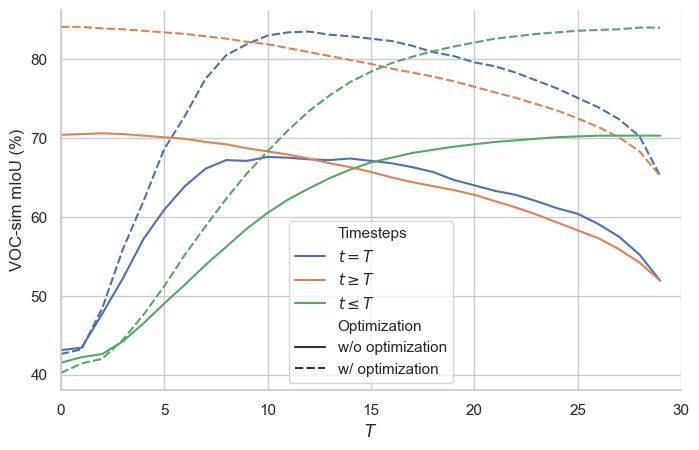

In [92]:
df = df_reresults.copy()
df = df[['timestep', 'strategy', 'miou_normal', 'miou_optimized']]
df["timestep"] -= 1
df

# Univots columns miou_normal and miou_optimized
df = pd.melt(df, id_vars=['timestep', 'strategy'], value_vars=['miou_normal', 'miou_optimized'], var_name='metric', value_name='value')
#df = df.query('metric != "miou_optimized"').copy()
df.metric.replace({'miou_normal': 'w/o optimization', 'miou_optimized': 'w/ optimization'}, inplace=True)




df.strategy.replace({"equal": '$t=T$', "greater_eq": '$t \geq T$', "less_eq": '$t \leq T$'}, inplace=True)
# Matplotlib theme (not whitgrid)

sns.set_theme(style="whitegrid")
phi_number = 0.61803398875
c = 8
fig, ax = plt.subplots(figsize=(c, phi_number*c))
df = df.rename(columns={'strategy': 'Timesteps', 'metric': 'Optimization'})

sns.lineplot(x="timestep", y="value", hue="Timesteps", style='Optimization', data=df, ax=ax)
sns.despine(ax=ax)
# Remove legend title
ax.legend(title=None)
ax.set_xlabel("$T$")
ax.set_ylabel("VOC-sim mIoU (%)")
ax.set_xlim(0, 30)
# Adds one decimal to yticks
#ax.yaxis.set_major_formatter('{x:.1f}')


df.to_csv("voc_sim_epochs.csv")
df

fig.savefig("voc_sim_epochs.pdf", bbox_inches='tight')

In [ ]:
df.query("Optimization == 'w/ optimization'").sort_values('value', ascending=False).head(20)